In [53]:
import numpy as np
import seaborn as sns
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, precision_score, precision_recall_fscore_support
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

In [54]:

df = pd.read_csv("C:/Users/kavya/OneDrive/Desktop/Spring2023_890/LoanFHLBData/original/y_2021.csv")

df.drop(['LoanNumber', 'AssignedID', 'Coop', 'Program', 'AcquDate', 'MortDate', 'Bed1', 'Bed2', 'Bed3', 'Bed4', 'Aff1',
         'Aff2', 'Aff3', 'Aff4', 'Occup', 'NumUnits', 'RentUt1', 'RentUt2', 'RentUt3', 'Product', 'RentUt4', 'Rent1',
         'Rent2', 'Rent3', 'Rent4', 'FeatureID', 'SellType', 'Seller', 'SellCity', 'SellSt', 'CICA', 'LienStatus',
         'FedFinStbltyPlan', 'GSEREO'], axis=1, inplace=True)
df.drop(['Tractrat','IncRat','Tractrat','FHFBID','Geog','SpcHsgGoals','AcqTyp'], axis=1, inplace=True)
df.head()

,Year,FHLBankID,FIPSStateCode,FIPSCountyCode,MSA,Tract,MinPer,TraMedY,LocMedY,Income,...,Race2,Race3,Race4,Race5,CoEth,Corace2,Corace3,Corace4,Corace5,HOEPA
0,2021,Boston,23,5,38860,45.02,6.379,91316,85144,11771,...,7,7,7,7,3,7,7,7,7,2
1,2021,Boston,23,5,38860,41.00,3.553,100396,85144,5651,...,7,7,7,7,5,8,8,8,8,2
2,2021,Boston,25,27,49340,7011.00,8.537,87500,91102,9395,...,7,7,7,7,5,8,8,8,8,2
3,2021,Boston,25,27,49340,7001.00,6.052,114531,91102,5912,...,7,7,7,7,2,7,7,7,7,2
4,2021,Boston,25,27,49340,7061.00,3.583,119423,91102,4420,...,7,7,7,7,5,8,8,8,8,2


In [55]:

dff = pd.read_csv("C:/Users/kavya/OneDrive/Desktop/Spring2023_890/LoanFHLBData/original/LoanData_preprocessed.csv")

# print(df)
dk = pd.DataFrame()
dk = dff[['FHLBankID', 'FIPSStateCode']]
df.isna().sum()
aa = dff[['FHLBankID', 'FIPSStateCode']]
fill_values = dict(dk.groupby('FIPSStateCode')['FHLBankID'].apply(lambda x: x.dropna().mode()[0]))

df['FHLBankID'] = df.apply(lambda x: fill_values[x['FIPSStateCode']] if pd.isnull(x['FHLBankID']) else x['FHLBankID'],
                           axis=1)
df.isna().sum()

Year              0
FHLBankID         0
FIPSStateCode     0
FIPSCountyCode    0
MSA               0
Tract             0
MinPer            0
TraMedY           0
LocMedY           0
Income            0
CurAreY           0
UPB               0
LTV               0
Purpose           0
FedGuar           0
Term              0
AmorTerm          0
NumBor            0
First             0
BoRace            0
CoRace            0
BoGender          0
CoGender          0
BoAge             0
CoAge             0
Rate              0
Amount            0
Front             0
Back              0
BoCreditScor      0
CoCreditScor      0
PMI               0
Self              0
PropType          0
ArmIndex          0
ArmMarg           0
PrepayP           0
BoEth             0
Race2             0
Race3             0
Race4             0
Race5             0
CoEth             0
Corace2           0
Corace3           0
Corace4           0
Corace5           0
HOEPA             0
dtype: int64

In [56]:

fhlbankid_encoder = LabelEncoder()
df['FHLBankID'] = fhlbankid_encoder.fit_transform(df['FHLBankID'])
proptype_encoder = LabelEncoder()
df['PropType'] = proptype_encoder.fit_transform(df['PropType'])

In [57]:

def date_to_numeric(date):
    if pd.isna(date):
        return 0
    else:
        try:
            date_obj = pd.to_datetime(date)
            if date_obj.year < 1970 or date_obj.year > 2100:
                return 0
            else:
                return int(date_obj.timestamp())
        except ValueError:
            return 0


df['PrepayP'] = df['PrepayP'].apply(date_to_numeric)

In [58]:
# # Convert the date column to an integer format
#
# # df['FHLBankID'] = label_encoder.fit_transform(df['FHLBankID','PropType'])
#
#
# """cols_with_missing = df.columns[df.isnull().any()].tolist()
#
# testdata=df[df.isnull().any(axis=1)]
# df.dropna(inplace=True)
#
# target=["Tractrat","IncRat"]
# X_train=df.loc[:,~df.columns.isin(target)]
# y_train=df.loc[:,df.columns.isin(target)]
# X_test=testdata.loc[:,~df.columns.isin(target)]
# y_test=testdata.loc[:,df.columns.isin(target)]
#
# clf = MultiOutputRegressor(RandomForestRegressor(max_depth=2, random_state=0))
# clf.fit(X_train, y_train)
# y_train.isnull().sum()
# y_pred=clf.predict(X_test)
# y_test=y_pred
# X_test[target]=y_pred
# X_train[target]=y_train
# df=X_train.append(X_test)
#
#
#
# """

In [59]:

df.isnull().any()

target = ["BoRace"]
X = df.loc[:, ~df.columns.isin(target)]
y = df.loc[:, df.columns.isin(target)]
feature_names = X.columns

In [60]:

scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
scaler = MinMaxScaler(feature_range=(0, 1))

In [61]:

selector = SelectKBest(chi2, k=10)
X_new = selector.fit_transform(X_scaled_df, y)
# print selected features
selected_features = selector.get_support(indices=True)
print([feature_names[i] for i in selected_features])
# """"""""uncomment for year classification""""
# Define the class labels
# class_labels = {2009: 0, 2010: 1, 2011: 2, 2012: 3, 2013: 4, 2014: 5, 2015: 6, 2016: 7, 2017: 8, 2018: 9, 2019: 10, 2020: 11, 2021: 12}

['MSA', 'Tract', 'MinPer', 'FedGuar', 'First', 'BoGender', 'CoAge', 'PropType', 'BoEth', 'CoEth']


In [62]:
unique_values = y['BoRace'].unique()
print(unique_values)

[6 5 3 2 4 1]


In [63]:
class_labels = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5}
y[target] = y[target].applymap(class_labels.get)
# Map the year values to class labels
unique_values = y['BoRace'].unique()
print(unique_values)

[5 4 2 1 3 0]


C:\Users\kavya\anaconda3\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [64]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.30, random_state=0)



xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=13, learning_rate=0.1, max_depth=6, n_estimators=100,
                              colsample_bytree=0.8)
# Train the XGBoost model on the training data
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

In [65]:
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)
print("Accuracy:", accuracy)

Precision: 0.9419461260528614
Recall: 0.9486095893984452
F1-score: 0.9416176430240881
Accuracy: 0.9486095893984452


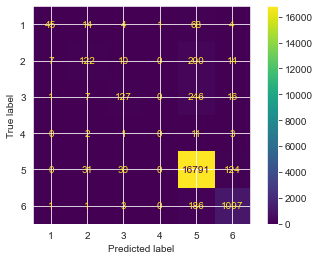

[[   45    14     4     1    68     4]
 [    7   122    10     0   200    14]
 [    1     7   127     0   246    16]
 [    0     2     1     0    11     3]
 [    0    31    30     0 16791   124]
 [    1     1     3     0   186  1097]]


In [66]:

from sklearn.metrics import confusion_matrix
from sklearn import metrics

# Assuming y_pred and y_true are the predicted and true labels respectively
cm = confusion_matrix(y_test, y_pred)
# classes=(df['Year'].unique())
classes = (df['BoRace'].unique())

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [1, 2,3,4,5,6])

cm_display.plot()
plt.show()
# .sort()

type(cm)
# Print the confusion matrix
print(cm)

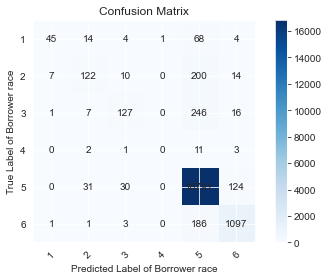

In [67]:
classes = [1, 2,3,4,5,6]
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.annotate(str(cm[i][j]), xy=(j, i), ha='center', va='center')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label of Borrower race')
plt.ylabel('True Label of Borrower race')
plt.tight_layout()
plt.show()

In [68]:


importances = xgb_model.feature_importances_
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})

# sort features by importance in descending order
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

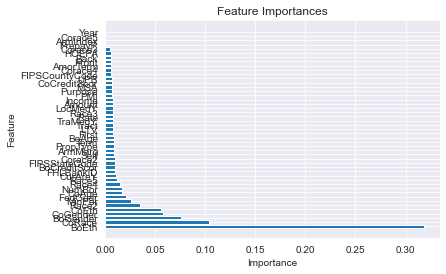

In [69]:

# plot feature importances
plt.barh(feature_importances['feature'], feature_importances['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

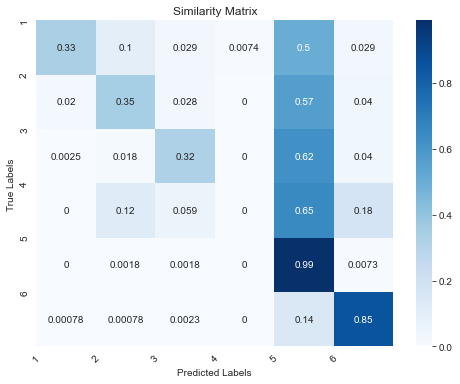

In [70]:

similarity_matrix = cm / cm.sum(axis=1, keepdims=True)
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_matrix, annot=True, cmap='Blues')
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.title('Similarity Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

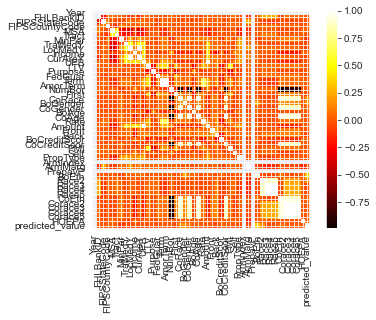

<Figure size 1080x720 with 0 Axes>

In [71]:

dx = pd.DataFrame(X_test, columns=X_test.columns)
dx["predicted_value"] = y_pred

corr_matrix = dx.corr()
plt.imshow(corr_matrix, cmap='hot', interpolation='nearest')
plt.xticks(range(len(dx.columns)), dx.columns)
plt.yticks(range(len(dx.columns)), dx.columns)
plt.xticks(rotation=90)
plt.colorbar()
plt.figure(figsize=(15, 10))
plt.subplots_adjust(bottom=0.15)
plt.show()

In [72]:

df['FHLBankID'] = fhlbankid_encoder.inverse_transform(df['FHLBankID'])
df['PropType'] = proptype_encoder.inverse_transform(df['PropType'])

In [73]:
"""Dummy classifier"""
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict(X_test)
dummy_clf.score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)
print("Accuracy:", accuracy)





Precision: 0.7844449064805473
Recall: 0.885688944540095
F1-score: 0.8319982028338905
Accuracy: 0.885688944540095


C:\Users\kavya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
